In [1]:
outdir = './s1_result'
import pandas as pd
import os
os.makedirs(outdir, exist_ok=True)

In [2]:
def get_individual_acc(fn, method, ref):
    df = pd.read_csv(fn, sep='\t')
    print('df.head():\n', df.head())

    # get the sum of num_correct and num_total for each individual
    df1 = df.groupby('sample')['num_correct'].sum().reset_index()
    df2 = df.groupby('sample')['num_total'].sum().reset_index()
    # merge df1 and df2
    df_grouped = pd.merge(df1, df2, on='sample')
    df_grouped['accuracy'] = df_grouped['num_correct'] / df_grouped['num_total'] * 100
    df_grouped['method'] = method
    df_grouped['ref'] = ref
    # add continent info by using df['sample'] and df['continent']
    id2continent = df[['sample', 'continent']].set_index('sample')['continent'].to_dict()
    df_grouped['continent'] = df_grouped['sample'].map(id2continent)
    print('df_grouped.head():\n', df_grouped.head())
    return df_grouped

all_dfs = []
for method in ['snpbag_base', 'snpbag_ft_omni']:
    fn = f'./s0_result/{method}.tsv'
    ref = method
    df_grouped = get_individual_acc(fn, method, ref)
    all_dfs.append(df_grouped)

phasings = ['beagle', 'shapeit', 'eagle']
imputations = ['beagle', 'minimac', 'impute']
refs = ['noREF', 'REF']
for phasing in phasings:
    for imputation in imputations:
        for ref in refs:
            method = f'{phasing}_{ref}_{imputation}'
            fn = f'./s0_result/{method}.tsv'
            df_grouped = get_individual_acc(fn, method, ref)
            df_grouped['method'] = method
            all_dfs.append(df_grouped)

df_all = pd.concat(all_dfs)
print('df_all.head():\n', df_all.head())

# save
df_all.to_csv(os.path.join(outdir, 'individual_acc.tsv'), sep='\t', index=False)


df.head():
    sample       maf_bin  num_wrong  num_correct  num_total  accuracy continent
0       0  [0.01, 0.03)        216         9084       9300  0.976774    EUROPE
1       0  [0.03, 0.06)        192        10127      10319  0.981394    EUROPE
2       0   [0.06, 0.1)        216        10236      10452  0.979334    EUROPE
3       0   [0.1, 0.18)        321        12577      12898  0.975112    EUROPE
4       0   [0.18, 0.3)        407        11261      11668  0.965118    EUROPE
df_grouped.head():
    sample  num_correct  num_total   accuracy       method          ref  \
0       0        63679      65690  96.938651  snpbag_base  snpbag_base   
1       1        63790      65690  97.107627  snpbag_base  snpbag_base   
2       2        63703      65690  96.975186  snpbag_base  snpbag_base   
3       3        63999      65690  97.425788  snpbag_base  snpbag_base   
4       4        64212      65690  97.750038  snpbag_base  snpbag_base   

            continent  
0              EUROPE  
1

In [3]:
# read df_all
df_all = pd.read_csv('./s1_result/individual_acc.tsv', sep='\t')
print('df_all.head():\n', df_all.head())

# group by method
df_grouped = df_all.groupby('method')['accuracy'].mean().reset_index()
print('df_grouped.head():\n', df_grouped.head())

# sort by accuracy
df_grouped = df_grouped.sort_values('accuracy', ascending=False)
print('df_grouped:\n', df_grouped)


df_all.head():
   sample  num_correct  num_total   accuracy       method          ref  \
0      0        63679      65690  96.938651  snpbag_base  snpbag_base   
1      1        63790      65690  97.107627  snpbag_base  snpbag_base   
2      2        63703      65690  96.975186  snpbag_base  snpbag_base   
3      3        63999      65690  97.425788  snpbag_base  snpbag_base   
4      4        64212      65690  97.750038  snpbag_base  snpbag_base   

            continent  
0              EUROPE  
1              EUROPE  
2              EUROPE  
3              EUROPE  
4  CENTRAL_SOUTH_ASIA  
df_grouped.head():
                 method   accuracy
0    beagle_REF_beagle  96.889034
1    beagle_REF_impute  97.104767
2   beagle_REF_minimac  96.582305
3  beagle_noREF_beagle  96.609707
4  beagle_noREF_impute  96.875361
df_grouped:
                    method   accuracy
19         snpbag_ft_omni  97.160731
1       beagle_REF_impute  97.104767
13     shapeit_REF_impute  97.087182
7        eagle_R

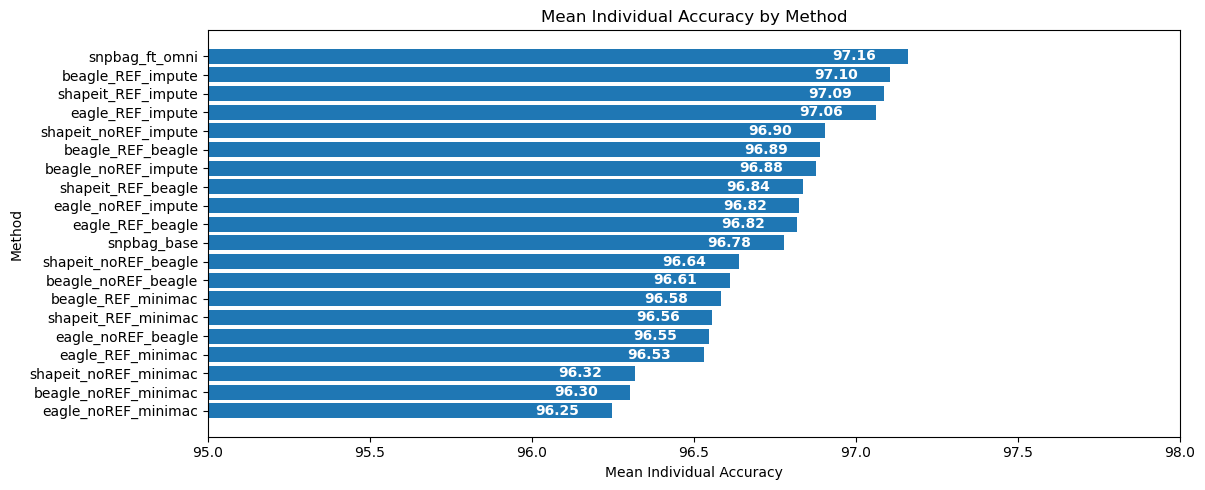

In [4]:

# plot the accuracy of each method as horizontal bars in reverse order
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
# Reverse the DataFrame order for plotting
df_grouped_rev = df_grouped.iloc[::-1]
bars = plt.barh(df_grouped_rev['method'], df_grouped_rev['accuracy'])
plt.xlabel('Mean Individual Accuracy')
plt.ylabel('Method')
plt.title('Mean Individual Accuracy by Method')
plt.yticks(rotation=0)
plt.tight_layout()
plt.xlim(95, 98)

# Add values at the bottom of each bar with white color
for bar, acc in zip(bars, df_grouped_rev['accuracy']):
    plt.text(
        bar.get_width() - 0.1,  # a little to the left of the bar end
        bar.get_y() + bar.get_height() / 2,
        f"{acc:.2f}",
        va='center',
        ha='right',
        color='white',
        fontsize=10,
        fontweight='bold'
    )

plt.show()